## Code for Mini Project

Amritpal Singh, Ozan Aygun, Ruth Gebremedhin

Used Resources:

https://github.com/kuangliu/pytorch-cifar (Shared in the assignment)

https://blog.paperspace.com/writing-resnet-from-scratch-in-pytorch/ 

Completed code for HW2-Q4.


In [192]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import _LRScheduler
import torch.utils.data as data

import torchvision.transforms as transforms
import torchvision.datasets as datasets

from sklearn import decomposition
from sklearn import manifold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

import copy
import random
import time

In [193]:
# Downloading the dataset
ROOT = '.data'
train_data = datasets.CIFAR10(root = ROOT, 
                              train = True, 
                              download = True)

Files already downloaded and verified


In [194]:
# Compute means and standard deviations along the R,G,B channel

means = train_data.data.mean(axis = (0,1,2)) / 255
stds = train_data.data.std(axis = (0,1,2)) / 255

In [195]:
# random flips and rotations to train datasets
train_transforms = transforms.Compose([
                           transforms.RandomRotation(5),
                           transforms.RandomHorizontalFlip(0.5),
                           transforms.RandomCrop(32, padding = 2),
                           transforms.ToTensor(),
                           transforms.Normalize(mean = means, 
                                                std = stds)
                       ])

test_transforms = transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean = means, 
                                                std = stds)
                       ])

In [196]:
# Construction training and test datasets
train_data = datasets.CIFAR10(ROOT, 
                              train = True, 
                              download = True, 
                              transform = train_transforms)

test_data = datasets.CIFAR10(ROOT, 
                             train = False, 
                             download = True, 
                             transform = test_transforms)

Files already downloaded and verified
Files already downloaded and verified


In [197]:
# Constructing validation dataset
VALID_RATIO = 0.9

n_train_examples = int(len(train_data) * VALID_RATIO)
n_valid_examples = len(train_data) - n_train_examples

train_data, valid_data = data.random_split(train_data, 
                                           [n_train_examples, n_valid_examples])

In [198]:
valid_data = copy.deepcopy(valid_data)
valid_data.dataset.transform = test_transforms

In [199]:
BATCH_SIZE = 64
# Dataloaders
train_iterator = torch.utils.data.DataLoader(train_data,batch_size= BATCH_SIZE,shuffle=True)

valid_iterator = torch.utils.data.DataLoader(valid_data,batch_size= BATCH_SIZE,shuffle=False)

test_iterator = torch.utils.data.DataLoader(test_data,batch_size= BATCH_SIZE,shuffle=False)

In [200]:
# Small convolutional blocks

# Construction of residual block using the basic block. 

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.dropout02 = nn.Dropout(p=0.2)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = self.dropout02(F.relu(self.bn1(self.conv1(x))))
        out = self.dropout02(self.bn2(self.conv2(out)))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


In [322]:
# Construction of custom resnet network using the small blocks defined above.

class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 32, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 64, num_blocks[1], stride=1)
        self.layer3 = self._make_layer(block, 128, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 256, num_blocks[3], stride=2)
        self.layer5 = self._make_layer(block, 512, num_blocks[4], stride=2)
        self.linear = nn.Linear(512, num_classes)


    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

In [323]:
# Parameter initialization using Kaiming normal.

def initialize_parameters(m):
    if isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight.data, nonlinearity = 'relu')
        nn.init.constant_(m.bias.data, 0)
    elif isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight.data, gain = nn.init.calculate_gain('relu'))
        nn.init.constant_(m.bias.data, 0)

In [324]:
num_classes = 10
learning_rate = 1e-3

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = ResNet(BasicBlock, [2, 1, 1, 1, 1]).to(device)
initialize_parameters(model)

# Loss and optimizer

optimizer = optim.Adam(model.parameters(), lr = learning_rate)
criterion = nn.CrossEntropyLoss()

model = model.to(device)
criterion = criterion.to(device)


Number of parameters:

In [325]:
print(sum(p.numel() for p in model.parameters() if p.requires_grad))

4935434


In [326]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (dropout02): Dropout(p=0.2, inplace=False)
      (shortcut): Sequential(
        (0): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): BasicBlock(
      (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2

In [327]:
# Function that calculates the accuracy
def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim = True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

In [328]:
# Training function used in previous homework
def train(model, iterator, optimizer, criterion, device):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for (x, y) in iterator:
        
        x = x.to(device)
        y = y.to(device)
        
        optimizer.zero_grad()
                
        y_pred = model(x)
        
        loss = criterion(y_pred, y)
        
        acc = calculate_accuracy(y_pred, y)
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [329]:
# Evaluate function taken from the previous homework.
def evaluate(model, iterator, criterion, device):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
        
        for (x, y) in iterator:

            x = x.to(device)
            y = y.to(device)

            y_pred = model(x)

            loss = criterion(y_pred, y)

            acc = calculate_accuracy(y_pred, y)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [330]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [331]:
EPOCHS = 40

valid_loss_vals = []
valid_acc_vals = []

temp_best_valid_loss = np.inf

for epoch in range(EPOCHS):
    # Time value has been stored for elapsed time
    start_time = time.time()
    # Training and performance outputs
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion, device)
    print("Epoch {}/{}, Training Loss: {:.3f}, Training Accuracy: {:.3f}".format(epoch+1,EPOCHS, train_loss, train_acc))
    # Evaluating with validation dataset
    valid_loss , valid_acc = evaluate(model, valid_iterator, criterion, device)
    # Keeping track of loss and accuracy values
    valid_loss_vals.append(valid_loss)
    valid_acc_vals.append(valid_acc)
    # Performance outputs
    print("Epoch {}/{}, Validation Loss: {:.3f}, Validation Accuracy: {:.3f}".format(epoch+1,EPOCHS, valid_loss, valid_acc))
    # If the current loss is better than the best loss so far, save the current model instead.
    if(temp_best_valid_loss > valid_loss):
      temp_best_valid_loss = valid_loss
      torch.save(model, 'cifar10_best_model.pt') 
    # End the timer and print the elapsed time in one epoch
    end_time = time.time()
    elapsed_mins, elapsed_secs = epoch_time(start_time, end_time)
    print("Total time: {:.3f} Minutes and {:.3f} Seconds".format(elapsed_mins, elapsed_secs))

Epoch 1/40, Training Loss: 1.400, Training Accuracy: 0.488
Epoch 1/40, Validation Loss: 1.089, Validation Accuracy: 0.622
Total time: 0.000 Minutes and 57.000 Seconds
Epoch 2/40, Training Loss: 0.992, Training Accuracy: 0.646
Epoch 2/40, Validation Loss: 0.899, Validation Accuracy: 0.686
Total time: 0.000 Minutes and 55.000 Seconds
Epoch 3/40, Training Loss: 0.831, Training Accuracy: 0.707
Epoch 3/40, Validation Loss: 0.803, Validation Accuracy: 0.717
Total time: 0.000 Minutes and 55.000 Seconds
Epoch 4/40, Training Loss: 0.719, Training Accuracy: 0.749
Epoch 4/40, Validation Loss: 0.702, Validation Accuracy: 0.765
Total time: 0.000 Minutes and 56.000 Seconds
Epoch 5/40, Training Loss: 0.643, Training Accuracy: 0.774
Epoch 5/40, Validation Loss: 0.684, Validation Accuracy: 0.769
Total time: 0.000 Minutes and 55.000 Seconds
Epoch 6/40, Training Loss: 0.591, Training Accuracy: 0.793
Epoch 6/40, Validation Loss: 0.651, Validation Accuracy: 0.776
Total time: 0.000 Minutes and 55.000 Second

In [332]:
# Load the best model and evaluate the accuracy on the test dataset.
torch.load('cifar10_best_model.pt') 
test_loss, test_acc = evaluate(model, test_iterator, criterion, device)
print("Test Loss: {:.3f}, Test Accuracy: {:.3f}".format(test_loss, test_acc))

Test Loss: 0.321, Test Accuracy: 0.911


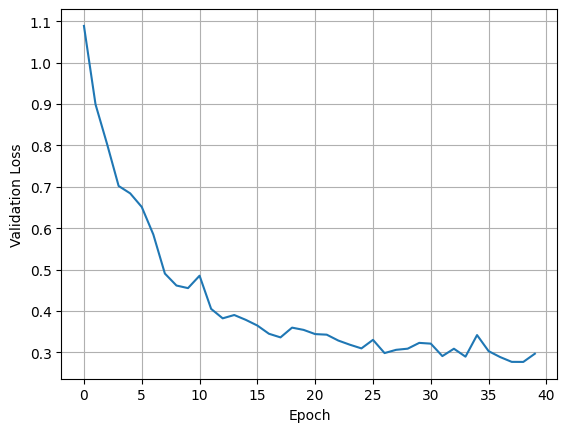

In [333]:
# Plotting the validation loss
epoch_no = np.arange(0, EPOCHS)
fig=plt.figure()
fig.show()
ax=fig.add_subplot(111)
ax.plot(epoch_no, valid_loss_vals)
plt.grid(True)
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.draw()

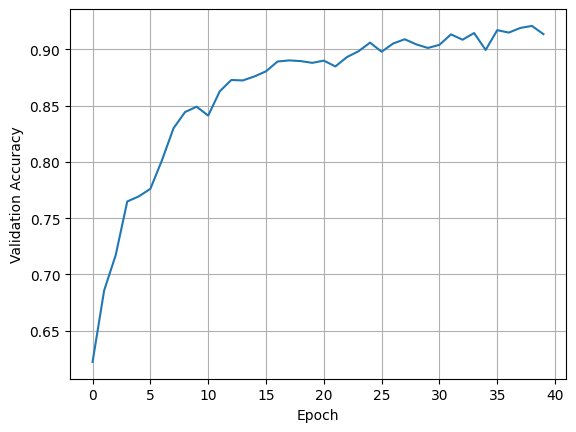

In [334]:
# Plotting the validation accuracy
fig=plt.figure()
fig.show()
ax=fig.add_subplot(111)
ax.plot(epoch_no, valid_acc_vals)
plt.grid(True)
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.draw()